In [2]:
import numpy as np
from scipy import stats

import mysql.connector
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

In [3]:
connector = mysql.connector.connect(
    host='localhost',
    user='root',
    password='password',
    database='naxos_db'
)

query = """
SELECT
    YEAR(release_date) AS year,
    label
FROM Album
WHERE release_date IS NOT NULL
    AND YEAR(release_date) BETWEEN 1990 AND 2023
"""

df = pd.read_sql(query, connector)
connector.close()

df.head()

C:\Users\jakob\AppData\Local\Temp\ipykernel_12232\4276259599.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connector)


,year,label
0,2014,SWR Jazzhaus
1,2013,SWR Jazzhaus
2,2013,SWR Jazzhaus
3,1997,White Cloud
4,1999,White Cloud


In [4]:
naxos_labels = [
    "Naxos World Music",
    "Naxos Special Projects",
    "Naxos Rock Legends",
    "Naxos Portara",
    "Naxos Nostalgia",
    "Naxos Jazz Legends",
    "Naxos Jazz Archives",
    "Naxos Jazz",
    "Naxos Japan",
    "Naxos International",
    "Naxos Instrumental",
    "Naxos Hörbucher",
    "Naxos Historical",
    "Naxos Educational",
    "Naxos Classical Archives",
    "Naxos AudioBooks",
    "Naxos"
]

naxos_group_labels = [
    "Allegretto",
    "Altissimo",
    "Amadis",
    "ARC",
    "BelAir Classiques",
    "belvedere edition",
    "bendigedig",
    "Capriccio",
    "Daphne Records",
    "Die Theateredition",
    "Dynamic",
    "Grand Piano",
    "Idil Biret Archive",
    "Marco Polo",
    "Musica Rediviva",
    "Musiques Suisses",
    "NXN Recordings",
    "Oehms Classics",
    "Ondine",
    "Opus Arte",
    "Orfeo",
    "Phoenix Edition",
    "Prophone",
    "Proprius",
    "Romophone",
    "Swedish Society",
    "SWR Classic",
    "SWR Jazzhaus",
    "Vox",
    "White Cloud",
    "Yellow River Chinese"
]

naxos_distributed = [
    "Accentus Music",
    "ArcoDiva",
    "Ars Nova",
    "Bayerische Staatsoper Recordings",
    "BR-Klassik",
    "C Major",
    "Campanella Musica",
    "Cantaloupe Music",
    "Cedille",
    "Christopher Nupen Films",
    "Dacapo",
    "Delos",
    "DSO Live",
    "Gramola Records",
    "MDR Klassik",
    "OUR Recordings",
    "Seventh Art Productions",
    "Solo Musica",
    "Dorian Sono Luminus",
    "Stradivarius",
    "Tactus",
    "Tafelmusik",
    "UNITEL Edition",
    "Vienna Philharmonic",
    "Wiener Johann Strauss Orchester",
    "Yarlung Records"
]

In [6]:
color_palette = [
  "#8dd3c7",
  "#bebada",
  "#ffffb3",
  "#fb8072",
  "#80b1d3",
  "#fdb462",
  "#b3de69",
  "#fccde5",
  "#d9d9d9",
  "#bc80bd",
  "#ccebc5",
  "#ffed6f"
]

#color_palette = plt.get_cmap('tab20').colors

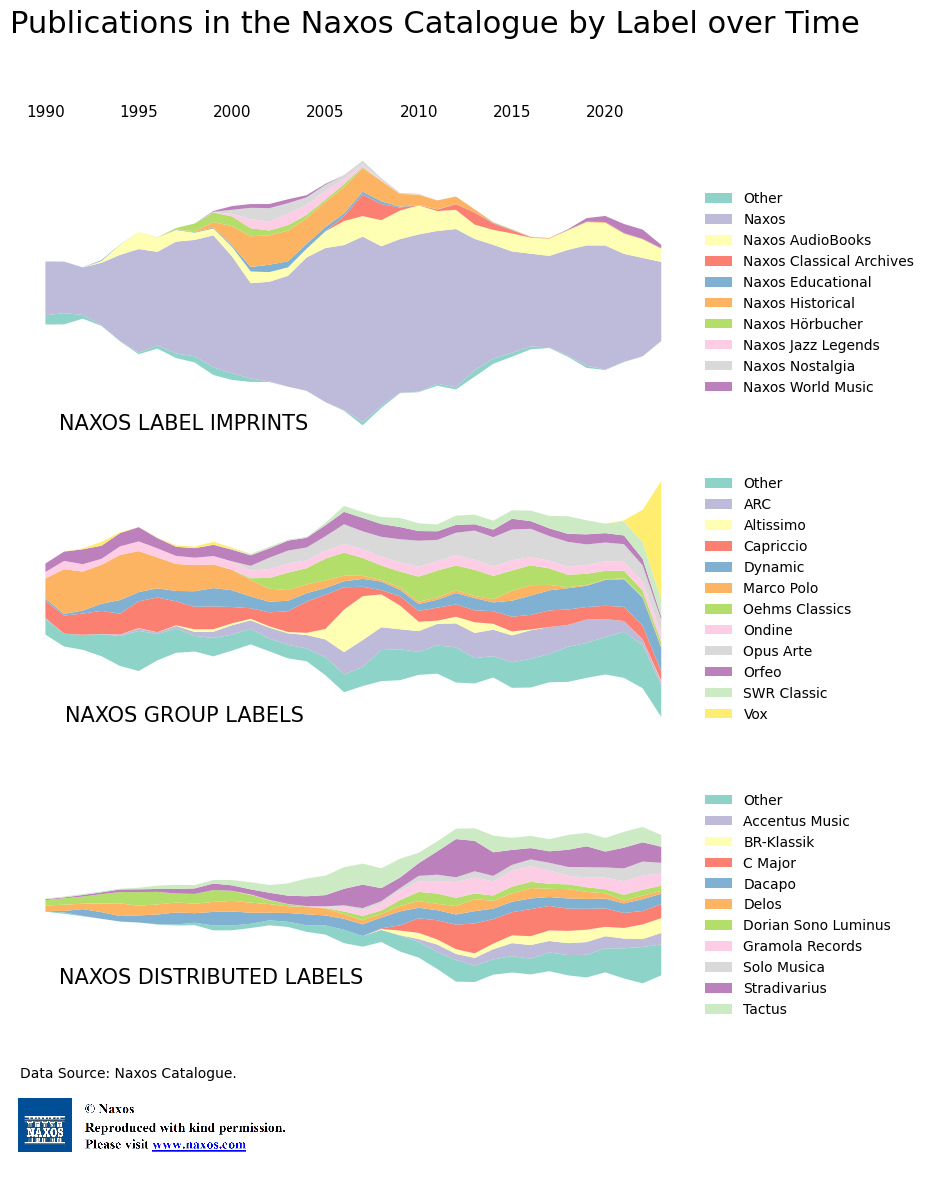

In [9]:
def stream_graph(df, labels, keep_n, std, ax):
    def gaussian_smooth(x, y, sd):
        weights = np.array([stats.norm.pdf(x, m, sd) for m in x])
        weights = weights / weights.sum(1)
        return (weights * y).sum(1)

    df = df.query('label in @labels').copy()

    to_replace = df.label.value_counts()[keep_n:].index.to_list()
    df = df.replace(to_replace, 'Other')

    label_counts = df.groupby(['year', 'label']).size().unstack(fill_value=0)
    
    # Ensure 'Other' is the first label and plotted at the bottom
    columns = label_counts.columns.tolist()
    if 'Other' in columns:
        columns.remove('Other')
        columns = ['Other'] + columns
    
    label_counts = label_counts[columns]
    labels = label_counts.columns
    years = label_counts.index
    values = label_counts.values.T
    values_smoothed = [gaussian_smooth(years, v, std) for v in values]

    #ax.set_facecolor('#fffcf5')
    ax.stackplot(years, values_smoothed, labels=labels, baseline='sym', colors=color_palette)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(left=False, bottom=False)
    ax.yaxis.set_visible(False)

    ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)



fig, axs = plt.subplots(3, 1, figsize=(5, 12), sharex=True, sharey=True)
#fig.patch.set_facecolor('#fffcf5')

stream_graph(df, naxos_labels, 9, 0.6, axs[0])
stream_graph(df, naxos_group_labels, 11, 0.6, axs[1])
stream_graph(df, naxos_distributed, 10, 0.6, axs[2])

fig.suptitle('Publications in the Naxos Catalogue by Label over Time', fontsize=22)

axs[0].text(
    0.25, 
    0.05, 
    'NAXOS LABEL IMPRINTS', 
    ha="center",
    va="center",
    ma="left",
    size=15,
    transform=axs[0].transAxes
)

axs[1].text(
    0.25, 
    0.1, 
    'NAXOS GROUP LABELS', 
    ha="center",
    va="center",
    ma="left",
    size=15,
    transform=axs[1].transAxes
)

axs[2].text(
    0.29, 
    0.25, 
    'NAXOS DISTRIBUTED LABELS', 
    ha="center",
    va="center",
    ma="left",
    size=15,
    transform=axs[2].transAxes
)


axs[0].xaxis.set_visible(True)
axs[2].xaxis.set_visible(False)
axs[0].tick_params(axis="x", labeltop=True, length=0, pad=20, labelsize=11)

fig.text(-0.33, 0.09, 'Data Source: Naxos Catalogue.')

image_path = 'naxos_link_trans.png'
image = mpimg.imread(image_path)
imagebox = OffsetImage(image, zoom=0.2)
ab = AnnotationBbox(
    imagebox,
    (0.3, 0.05),
    xycoords='figure fraction',
    boxcoords="offset points",
    frameon=False
)
fig.add_artist(ab)

plt.tight_layout(rect=[-0.45, 0.1, 1.5, 0.95])
plt.show()